# **Libraries :**

In [ ]:
# Core & System
import os
import cv2
import numpy as np
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Google Colab & File Handling
from google.colab import drive, files
import zipfile
import glob

# Data Handling & Analysis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# Image & Video Handling
import imageio
from imutils import paths
from IPython.display import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries (Keras & PyTorch)
import keras
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

# Progress Bars
from tqdm import tqdm

# YOLO for Person Detection
from ultralytics import YOLO



# **Data Import :**

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Shop DataSet.zip'
extract_to = '/content/ShopDataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/ShopDataset')


['Shop DataSet']

In [ ]:
#Set Paths to Folders

shoplifters = os.path.join(extract_to, 'Shop DataSet', 'shop lifters')
nonshoplifters = os.path.join(extract_to, 'Shop DataSet', 'non shop lifters')

# **EDA – Exploratory Data Analysis :**

In [ ]:
print("Shoplifters videos:", len(os.listdir(shoplifters)))
print("Non-shoplifters videos:", len(os.listdir(nonshoplifters)))


Shoplifters videos: 324
Non-shoplifters videos: 531


# **Preprocessing :**

In [ ]:
# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 25
MAX_SEQ_LENGTH = 16
NUM_FEATURES = 2048

In [ ]:
# Create dataframe from folders
def create_dataframe():
    video_paths = []
    labels = []

    for path in os.listdir(shoplifters):
        video_paths.append(os.path.join(shoplifters, path))
        labels.append("shoplifter")

    for path in os.listdir(nonshoplifters):
        video_paths.append(os.path.join(nonshoplifters, path))
        labels.append("non-shoplifter")

    return np.array(video_paths), np.array(labels)

video_paths, labels = create_dataframe()
print(f"Total videos: {len(video_paths)}")


Total videos: 855


In [ ]:
# Split train/test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42)


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim, start_x:start_x+min_dim]

def sample_frames_uniformly(frames, num_frames):
    total_frames = len(frames)
    if total_frames >= num_frames:
        indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
        return [frames[i] for i in indices]
    else:
        # If the video is short, we repeat the frames.
        repeat_factor = int(np.ceil(num_frames / total_frames))
        frames = frames * repeat_factor
        return frames[:num_frames]

def load_video(path, resize=(IMG_SIZE, IMG_SIZE), max_frames=MAX_SEQ_LENGTH):
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = crop_center_square(frame)
        frame = cv2.resize(frame, resize)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frames.append(frame)
    cap.release()

    # Select 16 Frame Distributors
    frames = sample_frames_uniformly(frames, max_frames)
    return np.array(frames)


In [ ]:
# Feature Extractor
def build_feature_extractor():
    base_model = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inputs)
    outputs = base_model(x)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()


In [ ]:
# Data Generator
class VideoFrameGenerator(keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(paths))
        self.label_map = {label: idx for idx, label in enumerate(np.unique(labels))}

    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        batch_features = np.zeros((len(batch_paths), MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
        batch_masks = np.zeros((len(batch_paths), MAX_SEQ_LENGTH), dtype="bool")
        batch_targets = np.zeros((len(batch_paths)), dtype="int32")

        for i, path in enumerate(batch_paths):
            frames = load_video(path)
            for j in range(MAX_SEQ_LENGTH):
                feat = feature_extractor.predict(frames[None, j, :], verbose=0)
                batch_features[i, j, :] = feat
            batch_masks[i, :] = 1
            batch_targets[i] = self.label_map[batch_labels[i]]

        return (batch_features, batch_masks), batch_targets

train_gen = VideoFrameGenerator(train_paths, train_labels, BATCH_SIZE)
test_gen = VideoFrameGenerator(test_paths, test_labels, BATCH_SIZE)

print(f"Train batches: {len(train_gen)}, Test batches: {len(test_gen)}")

Train batches: 86, Test batches: 22


# **CNN + GRU :**

In [ ]:
# Create label processor from current labels
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(labels)
)
print("Class vocabulary:", label_processor.get_vocabulary())

Class vocabulary: [np.str_('non-shoplifter'), np.str_('shoplifter')]


In [ ]:
# Sequence Model

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return rnn_model

def run_experiment():
    filepath = "video_classifier_best.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()

    # Print model summary
    print("\n Sequence Model Summary ")
    seq_model.summary()

    return seq_model, checkpoint, filepath


In [ ]:
# Run Training
seq_model, checkpoint, filepath = run_experiment()

history = seq_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    verbose=1
)

seq_model.load_weights(filepath)
_, accuracy = seq_model.evaluate(test_gen)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")



 Sequence Model Summary 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 16, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 16, 16)    │     99,168 │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8)         │        624 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8)         │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         72 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         18 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,882 (390.16 KB)

 Trainable params: 99,882 (390.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5119 - loss: 0.7178 
Epoch 1: val_loss improved from inf to 0.64373, saving model to video_classifier_best.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1563s 18s/step - accuracy: 0.5124 - loss: 0.7175 - val_accuracy: 0.6199 - val_loss: 0.6437
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5988 - loss: 0.6524 
Epoch 2: val_loss improved from 0.64373 to 0.58166, saving model to video_classifier_best.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1554s 18s/step - accuracy: 0.5989 - loss: 0.6523 - val_accuracy: 0.6199 - val_loss: 0.5817
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6307 - loss: 0.5887 
Epoch 3: val_loss improved from 0.58166 to 0.54509, saving model to video_classifier_best.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1591s 19s/step - accuracy: 0.6312 - loss: 0.5884 - val_accuracy: 0.8830 - val_loss: 0.5451
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7843 - loss: 0.5121 
Epoch 4

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

In [ ]:
train_acc = history.history["accuracy"][-1]       # last epoch
val_acc = history.history["val_accuracy"][-1]

# Model evaluation on test_gen
test_loss, test_acc = seq_model.evaluate(test_gen)

print(f"Training Accuracy   : {round(train_acc*100, 2)}%")
print(f"Validation Accuracy : {round(val_acc*100, 2)}%")
print(f"Testing Accuracy    : {round(test_acc*100, 2)}%")


In [ ]:
# Save the entire model(architecture + weights + optimizer)
MODEL_PATH = "video_sequence_model.h5"
seq_model.save(MODEL_PATH)
print(f"Model saved successfully at {MODEL_PATH}")

files.download(MODEL_PATH)


#**Pretrained (MAE) : preprocessing**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 25
MAX_SEQ_LENGTH = 16
NUM_FEATURES = 2048
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Create list of video paths and labels
video_paths, labels = [], []
for path in os.listdir(shoplifters):
    video_paths.append(os.path.join(shoplifters, path))
    labels.append(1)  # shoplifter = 1
for path in os.listdir(nonshoplifters):
    video_paths.append(os.path.join(nonshoplifters, path))
    labels.append(0)  # non-shoplifter = 0

In [ ]:
# Split train / val / test
train_paths, test_paths, y_train, y_test = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
val_paths, test_paths, y_val, y_test = train_test_split(
    test_paths, y_test, test_size=0.5, stratify=y_test, random_state=42
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 684, Val: 85, Test: 86


In [ ]:
#Dataset class
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames=MAX_SEQ_LENGTH, size=(IMG_SIZE, IMG_SIZE)):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.size = size

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, self.size)
            frames.append(frame)
        cap.release()

        total = len(frames)
        if total >= self.num_frames:
            indices = np.linspace(0, total - 1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]
        else:
            frames += [frames[-1]] * (self.num_frames - total)

        frames = np.array(frames, dtype=np.float32) / 255.0
        frames = torch.tensor(frames).permute(0, 3, 1, 2)  # (T, C, H, W)
        return frames, label


In [ ]:
# Model class
class EfficientNetB0_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_classes=1):
        super().__init__()
        backbone = efficientnet_b0(pretrained=True)
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        feats = self.backbone(x)
        feats = feats.view(b, t, -1)
        _, (h_n, _) = self.lstm(feats)
        h_n = h_n.squeeze(0)
        out = self.dropout(h_n)
        out = self.fc(out)
        return torch.sigmoid(out)


In [ ]:
# Dataloaders
train_dataset = VideoDataset(train_paths, y_train)
val_dataset = VideoDataset(val_paths, y_val)
test_dataset = VideoDataset(test_paths, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


#**Pretrained (MAE) : Building & Evaluation**

In [ ]:
# Training function
def train_model(epochs=EPOCHS):
    model = EfficientNetB0_LSTM().to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    f1_metric = BinaryF1Score().to(DEVICE)
    acc_metric = BinaryAccuracy().to(DEVICE)

    best_val_loss = float('inf')
    patience = 5
    no_improve_epochs = 0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'train_f1':[], 'val_f1':[]}

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, total_f1, total_acc = 0, 0, 0
        for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(videos).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = (outputs>0.5).int()
            total_loss += loss.item()
            total_f1 += f1_metric(preds, labels.int()).item()
            total_acc += acc_metric(preds, labels.int()).item()

        avg_loss = total_loss/len(train_loader)
        avg_f1 = total_f1/len(train_loader)
        avg_acc = total_acc/len(train_loader)
        history['train_loss'].append(avg_loss)
        history['train_f1'].append(avg_f1)
        history['train_acc'].append(avg_acc)

        # Validation
        model.eval()
        val_loss, val_f1, val_acc = 0,0,0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(DEVICE), labels.to(DEVICE)
                outputs = model(videos).squeeze(1)
                loss = criterion(outputs, labels)
                preds = (outputs>0.5).int()
                val_loss += loss.item()
                val_f1 += f1_metric(preds, labels.int()).item()
                val_acc += acc_metric(preds, labels.int()).item()

        avg_val_loss = val_loss/len(val_loader)
        avg_val_f1 = val_f1/len(val_loader)
        avg_val_acc = val_acc/len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(avg_val_f1)
        history['val_acc'].append(avg_val_acc)

        print(f"Epoch {epoch+1} -> Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
              f"Train F1: {avg_f1:.4f}, Val F1: {avg_val_f1:.4f} | Train Acc: {avg_acc:.4f}, Val Acc: {avg_val_acc:.4f}")

        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model improved — saved")
        else:
            no_improve_epochs +=1
            if no_improve_epochs >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(torch.load("best_model.pth"))
    return model, history


In [ ]:
# Evaluation function
def evaluate(model, loader, name="Eval"):
    criterion = nn.BCELoss()
    acc_metric = BinaryAccuracy().to(DEVICE)
    f1_metric = BinaryF1Score().to(DEVICE)
    model.eval()
    total_loss, total_acc, total_f1 = 0,0,0
    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos).squeeze(1)
            loss = criterion(outputs, labels)
            preds = (outputs>0.5).int()
            total_loss += loss.item()
            total_acc += acc_metric(preds, labels.int()).item()
            total_f1 += f1_metric(preds, labels.int()).item()
    n = len(loader)
    print(f"{name} -> Loss: {total_loss/n:.4f}, Acc: {total_acc/n:.4f}, F1: {total_f1/n:.4f}")


In [ ]:
# Run Training & Evaluation
model, history = train_model(EPOCHS)

print('Training Results:')
evaluate(model, train_loader, "Train")

print("\nValidation Results:")
evaluate(model, val_loader, "Validation")

print("\nTest Results:")
evaluate(model, test_loader, "Test")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 164MB/s]
Epoch 1: 100%|██████████| 86/86 [06:02<00:00,  4.21s/it]


Epoch 1 -> Train Loss: 0.6198, Val Loss: 0.4639 | Train F1: 0.2013, Val F1: 0.7416 | Train Acc: 0.6512, Val Acc: 0.8523
Model improved — saved


Epoch 2: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 2 -> Train Loss: 0.3555, Val Loss: 0.1383 | Train F1: 0.8187, Val F1: 0.9616 | Train Acc: 0.8794, Val Acc: 0.9659
Model improved — saved


Epoch 3: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 3 -> Train Loss: 0.2649, Val Loss: 0.1007 | Train F1: 0.8397, Val F1: 0.9715 | Train Acc: 0.8910, Val Acc: 0.9659
Model improved — saved


Epoch 4: 100%|██████████| 86/86 [05:51<00:00,  4.09s/it]


Epoch 4 -> Train Loss: 0.1439, Val Loss: 0.0469 | Train F1: 0.9134, Val F1: 1.0000 | Train Acc: 0.9477, Val Acc: 1.0000
Model improved — saved


Epoch 5: 100%|██████████| 86/86 [05:50<00:00,  4.08s/it]


Epoch 5 -> Train Loss: 0.1659, Val Loss: 0.0723 | Train F1: 0.9066, Val F1: 0.9769 | Train Acc: 0.9419, Val Acc: 0.9773


Epoch 6: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 6 -> Train Loss: 0.1264, Val Loss: 0.0342 | Train F1: 0.9181, Val F1: 1.0000 | Train Acc: 0.9680, Val Acc: 1.0000
Model improved — saved


Epoch 7: 100%|██████████| 86/86 [05:58<00:00,  4.17s/it]


Epoch 7 -> Train Loss: 0.1231, Val Loss: 0.0456 | Train F1: 0.9273, Val F1: 0.9870 | Train Acc: 0.9680, Val Acc: 0.9886


Epoch 8: 100%|██████████| 86/86 [06:05<00:00,  4.25s/it]


Epoch 8 -> Train Loss: 0.0759, Val Loss: 0.0246 | Train F1: 0.9509, Val F1: 0.9870 | Train Acc: 0.9782, Val Acc: 0.9886
Model improved — saved


Epoch 9: 100%|██████████| 86/86 [05:56<00:00,  4.14s/it]


Epoch 9 -> Train Loss: 0.0959, Val Loss: 0.0211 | Train F1: 0.9476, Val F1: 1.0000 | Train Acc: 0.9753, Val Acc: 1.0000
Model improved — saved


Epoch 10: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 10 -> Train Loss: 0.0633, Val Loss: 0.0272 | Train F1: 0.9636, Val F1: 0.9870 | Train Acc: 0.9840, Val Acc: 0.9886


Epoch 11: 100%|██████████| 86/86 [05:57<00:00,  4.16s/it]


Epoch 11 -> Train Loss: 0.0752, Val Loss: 0.0168 | Train F1: 0.9332, Val F1: 1.0000 | Train Acc: 0.9782, Val Acc: 1.0000
Model improved — saved


Epoch 12: 100%|██████████| 86/86 [05:56<00:00,  4.15s/it]


Epoch 12 -> Train Loss: 0.0524, Val Loss: 0.0149 | Train F1: 0.9654, Val F1: 1.0000 | Train Acc: 0.9811, Val Acc: 1.0000
Model improved — saved


Epoch 13: 100%|██████████| 86/86 [05:54<00:00,  4.12s/it]


Epoch 13 -> Train Loss: 0.0561, Val Loss: 0.0106 | Train F1: 0.9635, Val F1: 1.0000 | Train Acc: 0.9811, Val Acc: 1.0000
Model improved — saved


Epoch 14: 100%|██████████| 86/86 [06:01<00:00,  4.20s/it]


Epoch 14 -> Train Loss: 0.0393, Val Loss: 0.0107 | Train F1: 0.9820, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000


Epoch 15: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 15 -> Train Loss: 0.0306, Val Loss: 0.0060 | Train F1: 0.9627, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000
Model improved — saved


Epoch 16: 100%|██████████| 86/86 [05:56<00:00,  4.15s/it]


Epoch 16 -> Train Loss: 0.0246, Val Loss: 0.0056 | Train F1: 0.9694, Val F1: 1.0000 | Train Acc: 0.9927, Val Acc: 1.0000
Model improved — saved


Epoch 17: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 17 -> Train Loss: 0.0987, Val Loss: 0.0082 | Train F1: 0.8780, Val F1: 1.0000 | Train Acc: 0.9608, Val Acc: 1.0000


Epoch 18: 100%|██████████| 86/86 [05:49<00:00,  4.07s/it]


Epoch 18 -> Train Loss: 0.0301, Val Loss: 0.0061 | Train F1: 0.9565, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000


Epoch 19: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 19 -> Train Loss: 0.0203, Val Loss: 0.0044 | Train F1: 0.9599, Val F1: 1.0000 | Train Acc: 0.9956, Val Acc: 1.0000
Model improved — saved


Epoch 20: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 20 -> Train Loss: 0.0697, Val Loss: 0.0060 | Train F1: 0.9678, Val F1: 1.0000 | Train Acc: 0.9811, Val Acc: 1.0000


Epoch 21: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 21 -> Train Loss: 0.0206, Val Loss: 0.0048 | Train F1: 0.9511, Val F1: 1.0000 | Train Acc: 0.9956, Val Acc: 1.0000


Epoch 22: 100%|██████████| 86/86 [05:51<00:00,  4.09s/it]


Epoch 22 -> Train Loss: 0.0393, Val Loss: 0.0070 | Train F1: 0.9639, Val F1: 1.0000 | Train Acc: 0.9898, Val Acc: 1.0000


Epoch 23: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 23 -> Train Loss: 0.0284, Val Loss: 0.0036 | Train F1: 0.9695, Val F1: 1.0000 | Train Acc: 0.9898, Val Acc: 1.0000
Model improved — saved


Epoch 24: 100%|██████████| 86/86 [05:53<00:00,  4.11s/it]


Epoch 24 -> Train Loss: 0.0243, Val Loss: 0.0036 | Train F1: 0.9740, Val F1: 1.0000 | Train Acc: 0.9942, Val Acc: 1.0000
Model improved — saved


Epoch 25: 100%|██████████| 86/86 [05:50<00:00,  4.08s/it]


Epoch 25 -> Train Loss: 0.0237, Val Loss: 0.0033 | Train F1: 0.9547, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000
Model improved — saved
Training Results:
Train -> Loss: 0.0032, Acc: 1.0000, F1: 0.9651

Validation Results:
Validation -> Loss: 0.0033, Acc: 1.0000, F1: 1.0000

Test Results:
Test -> Loss: 0.0033, Acc: 1.0000, F1: 1.0000


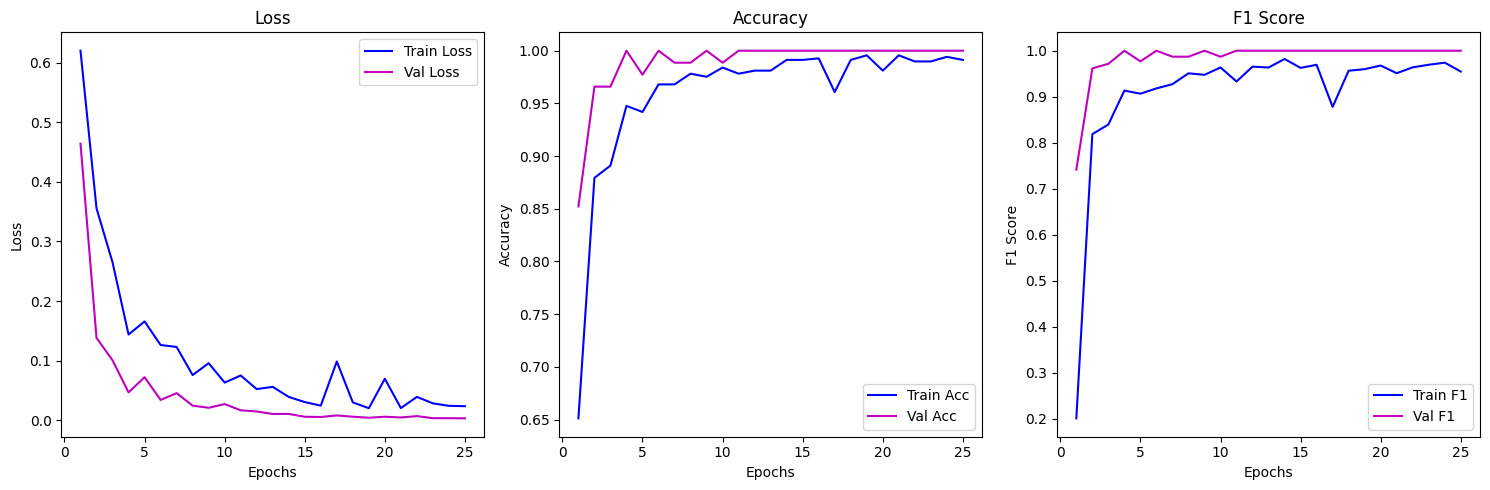

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='b')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='m')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', color='b')
    plt.plot(epochs, history['val_acc'], label='Val Acc', color='m')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1', color='b')
    plt.plot(epochs, history['val_f1'], label='Val F1', color='m')
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.title("F1 Score")

    plt.tight_layout()
    plt.show()

plot_training_history(history)


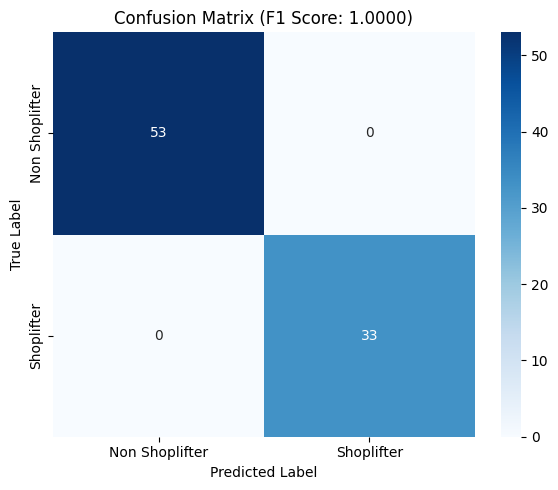

In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in dataloader:
            videos, labels = videos.float().to(device), labels.to(device)
            outputs = model(videos)
            preds = (outputs.squeeze(1) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, pos_label=1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (F1 Score: {f1:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, test_loader, ["Non Shoplifter", "Shoplifter"], DEVICE)


In [ ]:
IMG_SIZE = 224  # Make sure it is the same size used for training

def predict_video(model, video_path, device, threshold=0.5):
    model.eval()
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame_rgb, (IMG_SIZE, IMG_SIZE))
        frame_tensor = torch.tensor(frame_resized).permute(2, 0, 1).float() / 255.0
        frames.append(frame_tensor)
    cap.release()

    if len(frames) == 0:
        raise ValueError("No frames found in video.")

    video_tensor = torch.stack(frames).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(video_tensor).squeeze(1)
        prob = torch.sigmoid(outputs).item()

    predicted_class = "Shoplifter" if prob > threshold else "Non Shoplifter"
    return predicted_class, prob

# Try predicting on a new video.
video_path = '/content/ShopDataset/Shop DataSet/shop lifters/shop_lifter_36.mp4'
label, prob = predict_video(model, video_path, DEVICE)
print(f'Prediction: {label} (Confidence: {prob:.4f})')


Prediction: Shoplifter (Confidence: 0.7298)


Video saved as 'output.mp4'


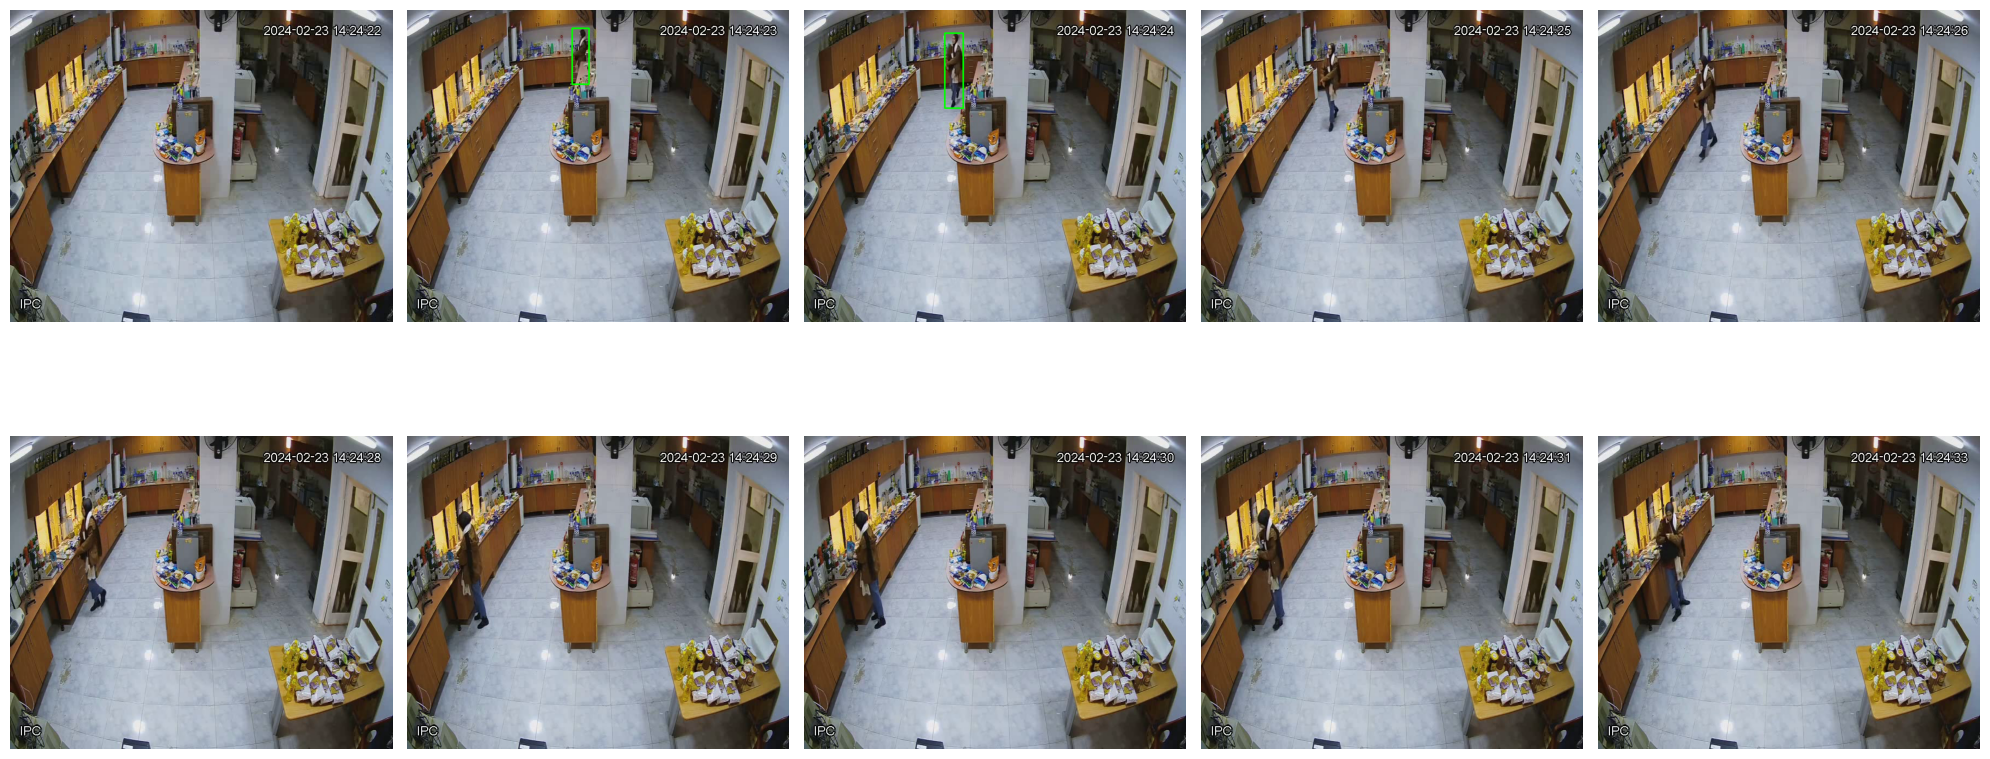

In [ ]:
def visualize_frames(vid_path):
    yolo_model = YOLO('yolov8n.pt')  # Pretrained YOLOv8 Model

    cap = cv2.VideoCapture(vid_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

    frames_to_show = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = yolo_model.predict(frame, classes=[0], verbose=False)
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        out.write(frame)
        if frame_count % 30 == 0:
            frames_to_show.append(frame.copy())
        frame_count += 1

    cap.release()
    out.release()
    print("Video saved as 'output.mp4'")

    while len(frames_to_show) < 10:
        frames_to_show.append(np.zeros_like(frames_to_show[0]))

    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(frames_to_show[i], cv2.COLOR_BGR2RGB))
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_frames(video_path)


In [ ]:
# Save Model
MODEL_PATH = "shoplifter_model.pth"

# Save model wieghts
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved successfully at: {MODEL_PATH}")

#  Download Model
files.download(MODEL_PATH)


 Model saved successfully at: shoplifter_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deployment :**